In [1]:
!pip install nbimporter

In [2]:
import numpy as np
import tensorflow as tf
from time import time
import sys
from dataLoader import loadData
import os

In [3]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [4]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [5]:
seed = 47
np.random.seed(seed)

In [6]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 4.591748237609863 seconds
loaded dense data matrix


In [7]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [8]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [11]:
get_sparsity(tr)

4.021525859265269

In [12]:
get_sparsity(vr)

0.44683670296601535

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.init as init
from os.path import isfile, isdir, join
import os

In [14]:
lrD = 5e-4
lrG = 5e-4
batch_size = 64
cuda = True
epochs = 0 #change
nz = 10
d_iter = 5
g_iter = 1
lamba = 1e-3 # constant for L2 penalty (diversity)

In [15]:
train = tr.copy()

In [16]:
if torch.cuda.is_available()==True:
    device="cuda"
else:
    device ="cpu"

In [17]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
        filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())/(fake == 0).sum()
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
        x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.net = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
                                torch.nn.ReLU(), 
                                torch.nn.Linear(1024, 1024), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.5),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.6)
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.net(x)
#         return x
        return x*5 # to get values in range [0,5]
    
# networks
netD = NetD().to(device)
netG = NetG().to(device)
print(netG)
print(netD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
one = torch.FloatTensor([1])
mone = one * -1

NetG(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Dropout(p=0.5)
    (5): Linear(in_features=1024, out_features=3706, bias=True)
    (6): Sigmoid()
    (7): Dropout(p=0.6)
  )
)
NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)


In [18]:
one = torch.FloatTensor([1]).to(device)
mone = (one * -1).to(device)

In [19]:
for p in netD.parameters(): # reset requires_grad
    p.requires_grad = True #
    
for p in netG.parameters(): # reset requires_grad
    p.requires_grad = True #

In [20]:
def get_random_batch(mat, batch_size=16):
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [21]:
get_random_batch(train, batch_size=batch_size).shape

(64, 3706)

In [22]:
train = torch.autograd.Variable(torch.Tensor(train))

In [23]:
def d_my(x_r, x_g): # custom loss -todo
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r))

In [53]:
steps_per_epoch = 300
gen_iterations = 0
eval_losses = []
for epoch in range(0):
#     data_iter = iter(data_loader)
    i = 0
    while i < steps_per_epoch:
        ############################
        # (1) Update D network
        ###########################
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        d_iter = d_iter
        j = 0
        while j < d_iter*5:
            j += 1
            # load real data
            i += 1
#             X, _ = data_iter.next()
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             print(X >= 0.5)
# #             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            # generate fake data
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            with torch.no_grad():
                noisev = Variable(noise) # totally freeze netG
            fake = Variable(netG(noisev).data)
#             print(real[0,:20], fake[0,:20])
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             real + fake * (real == 0).float()
#             print(real[0,:20], fake[0,:20])
            fake.requires_grad = False
#             print(real.shape, fake.shape)
    
            # compute gradient, take step
            netD.zero_grad()
#             print('real', real[:10, :20])
#             print('fake', fake[:10, :20])
#             print(real.type(), fake.type())
#             print(fake)
            out = netD(real, fake)
            
            outputD = torch.mean(out) + lamba * out.norm()
            stdD = torch.std(out)
            outputD.backward(mone)
            optimizerD.step()
#             print(out.shape)
        ############################
        # (2) Update G network
        ###########################
        g_iter = g_iter
        j = 0
        while j < g_iter*5:
            j += 1
            for p in netD.parameters():
                p.requires_grad = False # to avoid computation
            netG.zero_grad()
            
            # load real data
            i += 1
            X = get_random_batch(train, batch_size=batch_size)
#             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
#             X = X.view(X.size(0), -1)
#             X = (X >= 0.5).float()
            if cuda: 
                X = X.cuda()
            real = Variable(X)
            
            # update generator
            noise = torch.randn(batch_size, nz)
            if cuda: 
                noise = noise.cuda()
            noisev = Variable(noise)
            
            fake = netG(noisev)
            real + fake * (real == 0).float()
            fake = fake * Variable(real != 0).float().cuda()
#             fake = fake * Variable(real != 0).float().cuda()
#             fake.requires_grad = False
#             fake = Variable(netG(noisev)).data
#             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
#             fake.requires_grad = True
            
            out = netD(real, fake)
            outputG = torch.mean(out) + lamba * out.norm()
            stdG = torch.std(out)
            outputG.backward(one)
            optimizerG.step()

            gen_iterations += 1

#             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
#             print('output_D', outputD.item(), gen_iterations)
#             print('output_G', outputG.item(), gen_iterations)
#             print('std_D', stdD.item(), gen_iterations)
#             print('std_G', stdG.item(), gen_iterations)
            torch.save(netG.state_dict(), './netG-1m')
            torch.save(netD.state_dict(), './netD-1m')
            # evaluation
            if gen_iterations % 100 == 0: # todo- to change
#                 gen.eval()
#                 z_vector_eval = make_some_noise(128)
#                 fake_rows_eval = gen(z_vector_eval)
#                 real_rows_eval = get_random_batch(train, 128)
        #         print(fake_rows[0][:10]) enable to see some results
#                 fake = Variable(netG(noisev).data).round()
#                 fake = ((real != 0) & (fake != 0))
#                 print(fake)
                eval_loss = F.mse_loss(fake, real, reduction='mean')
                eval_losses.append(eval_loss)
                print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake)))
                print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))

Epoch number 1. my distance between random real and fake samples 33754.09375
Epoch number 1. MSE distance between random real and fake samples 0.5465670824050903
Epoch number 3. my distance between random real and fake samples 33166.625
Epoch number 3. MSE distance between random real and fake samples 0.5593405365943909
Epoch number 5. my distance between random real and fake samples 43156.2890625
Epoch number 5. MSE distance between random real and fake samples 0.7913061380386353
Epoch number 7. my distance between random real and fake samples 38046.9609375
Epoch number 7. MSE distance between random real and fake samples 0.7794598340988159
Epoch number 9. my distance between random real and fake samples 46134.140625
Epoch number 9. MSE distance between random real and fake samples 0.992827832698822
Epoch number 11. my distance between random real and fake samples 50504.90625
Epoch number 11. MSE distance between random real and fake samples 1.0978482961654663
Epoch number 13. my dist

KeyboardInterrupt: 

In [25]:
# torch.save(netG.state_dict(), './netG-1m')
# torch.save(netD.state_dict(), './netD-1m')

In [26]:
import matplotlib.pyplot as plt

plt.plot(eval_losses)
plt.show()

<Figure size 640x480 with 1 Axes>

In [27]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG(noisev)

In [28]:
fake.shape

torch.Size([6040, 3706])

In [29]:
fake = np.around(fake.detach().cpu().numpy())

In [30]:
np.unique(fake)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
      dtype=float32)

In [31]:
fake = fake * (fake <= 5).astype(int)

In [32]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 1745156 226310
4 611182 348971
3 89871 261197
2 2832 107557
1 1 56174
0 19935198 21384031


In [33]:
train > 3 

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [34]:
get_sparsity(train > 3)

8.934857739195076e-06

In [35]:
(train[0,:] > 3).sum()

tensor(43)

In [36]:
train

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]])

In [37]:
train = torch.Tensor(tr.copy()).to(device)

In [38]:
get_sparsity(train.cpu().numpy())

4.021525859265269

In [39]:
train > 3

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)

In [40]:
zero_mask = (train == 0).to(device).float()

In [41]:
positive_feedback_mask = (train > 3).to(device).float()

In [42]:
negative_feedback_mask = ((train < 4).to(device).float() * (1 - zero_mask)).to(device).float()

In [43]:
((positive_feedback_mask + negative_feedback_mask) != zero_mask).all()

tensor(1, device='cuda:0', dtype=torch.uint8)

In [44]:
get_sparsity(negative_feedback_mask.cpu().numpy())

1.7090908603553212

TRAINING DENOISING AUTOENCODER ON NEGATIVE FEEDBACKS

In [178]:
class denoising_autoencoder(nn.Module):
    def __init__(self, input_size, z=64):
        super(denoising_autoencoder, self).__init__()
        self.encoder=nn.Sequential(
                      nn.Linear(input_size, 1024),
                      nn.ReLU(),
                      nn.Linear(1024,512),
                      nn.ReLU(),
                      nn.Linear(512, z),
                      nn.Sigmoid()
                      )

        self.decoder=nn.Sequential(
                      nn.Linear(z, 512),
                      nn.ReLU(),
                      nn.Linear(512, 1024),
                      nn.ReLU(),
                      nn.Linear(1024, input_size),
                      nn.Sigmoid(),
                      )
    
 
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)*5
    
        return x

In [179]:
model = denoising_autoencoder(input_size=train[0,:].shape[0]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001, weight_decay=1e-5)

In [180]:
model

denoising_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3706, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=64, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3706, bias=True)
    (5): Sigmoid()
  )
)

In [181]:
def get_random_masked_batch(mat, batch_size = 32, p=0.5):
    '''
    This works as a trainloader for denoising autoencoder.
    Randomly masks observed entries (replaces 1s with 0s) to add a noise
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(rand_rows)
#     return mat[rand_rows], mat[rand_rows]
    orig = mat[rand_rows].clone()
    corrupted = mat[rand_rows].clone()
    mask_arr = torch.FloatTensor((np.random.rand(orig.shape[0], orig.shape[1]) > p)).to(device)

    return orig, corrupted*mask_arr, rand_rows

orig, masked, _ = get_random_masked_batch(negative_feedback_mask)

In [182]:
get_sparsity(orig.cpu().numpy())

2.130835132218025

In [183]:
get_sparsity(masked.cpu().numpy())

1.0666824069077172

In [184]:
get_sparsity(torch.nn.functional.dropout(masked, training=False).cpu().numpy())

1.0666824069077172

In [185]:
# torch.nn.functional.dropout(orig, training=False)

In [186]:
epochs = 120
# l = len(trainloader)
l = 120
losslist = []
epochloss = 0
running_loss = 0
steps_per_epoch = 200

for epoch in range(epochs):
  
    print("Entering Epoch: ", epoch)
    for i in range(steps_per_epoch):
        orig, masked, _ = get_random_masked_batch(train)

        #-----------------Forward Pass----------------------
        output = model(masked)
        loss = criterion(output, orig)
        #-----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
        #-----------------Log-------------------------------
        losslist.append(running_loss/l)
        running_loss=0
#     print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))
        print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))

Entering Epoch:  0
======> epoch: 0/120, Loss:6.112618446350098
======> epoch: 0/120, Loss:6.100712299346924
======> epoch: 0/120, Loss:6.09622049331665
======> epoch: 0/120, Loss:6.042975425720215
======> epoch: 0/120, Loss:6.074939727783203
======> epoch: 0/120, Loss:6.046957015991211
======> epoch: 0/120, Loss:6.067080974578857
======> epoch: 0/120, Loss:6.0212202072143555
======> epoch: 0/120, Loss:6.08786678314209
======> epoch: 0/120, Loss:6.09821081161499
======> epoch: 0/120, Loss:5.993112087249756
======> epoch: 0/120, Loss:6.074583530426025
======> epoch: 0/120, Loss:6.003083229064941
======> epoch: 0/120, Loss:6.0777363777160645
======> epoch: 0/120, Loss:6.058883190155029
======> epoch: 0/120, Loss:6.046721458435059
======> epoch: 0/120, Loss:6.030058860778809
======> epoch: 0/120, Loss:6.038345813751221
======> epoch: 0/120, Loss:6.010257720947266
======> epoch: 0/120, Loss:6.094259738922119
======> epoch: 0/120, Loss:6.0198588371276855
======> epoch: 0/120, Loss:5.9930958

======> epoch: 0/120, Loss:3.287432909011841
======> epoch: 0/120, Loss:3.3774547576904297
======> epoch: 0/120, Loss:3.168419361114502
======> epoch: 0/120, Loss:3.3123316764831543
======> epoch: 0/120, Loss:3.211751699447632
======> epoch: 0/120, Loss:3.128321886062622
======> epoch: 0/120, Loss:3.1027615070343018
======> epoch: 0/120, Loss:3.139885663986206
======> epoch: 0/120, Loss:3.0701494216918945
======> epoch: 0/120, Loss:3.139519691467285
======> epoch: 0/120, Loss:2.947161912918091
======> epoch: 0/120, Loss:3.0512001514434814
======> epoch: 0/120, Loss:2.892031669616699
======> epoch: 0/120, Loss:2.8324391841888428
======> epoch: 0/120, Loss:2.8225502967834473
======> epoch: 0/120, Loss:2.9199378490448
======> epoch: 0/120, Loss:2.823819875717163
======> epoch: 0/120, Loss:2.820059061050415
======> epoch: 0/120, Loss:2.7895421981811523
Entering Epoch:  1
======> epoch: 1/120, Loss:2.7734920978546143
======> epoch: 1/120, Loss:2.7134034633636475
======> epoch: 1/120, Loss:2

======> epoch: 1/120, Loss:0.866227924823761
======> epoch: 1/120, Loss:0.655539870262146
======> epoch: 1/120, Loss:0.8385001420974731
======> epoch: 1/120, Loss:0.7095603942871094
======> epoch: 1/120, Loss:0.7218925952911377
======> epoch: 1/120, Loss:0.6955533623695374
======> epoch: 1/120, Loss:0.6529923677444458
======> epoch: 1/120, Loss:0.7159011960029602
======> epoch: 1/120, Loss:0.6285911202430725
======> epoch: 1/120, Loss:0.6754326820373535
======> epoch: 1/120, Loss:0.6888651251792908
======> epoch: 1/120, Loss:0.7104061245918274
======> epoch: 1/120, Loss:0.7346985936164856
======> epoch: 1/120, Loss:0.6080597043037415
======> epoch: 1/120, Loss:0.6925898790359497
======> epoch: 1/120, Loss:0.6941189169883728
======> epoch: 1/120, Loss:0.6790207028388977
======> epoch: 1/120, Loss:0.7608843445777893
======> epoch: 1/120, Loss:0.7242164015769958
======> epoch: 1/120, Loss:0.5950841307640076
======> epoch: 1/120, Loss:0.6197346448898315
======> epoch: 1/120, Loss:0.6591216

======> epoch: 2/120, Loss:0.5274749994277954
======> epoch: 2/120, Loss:0.5555964708328247
======> epoch: 2/120, Loss:0.5119743943214417
======> epoch: 2/120, Loss:0.47417670488357544
======> epoch: 2/120, Loss:0.6027199029922485
======> epoch: 2/120, Loss:0.7688403725624084
======> epoch: 2/120, Loss:0.6135662198066711
======> epoch: 2/120, Loss:0.6011142730712891
======> epoch: 2/120, Loss:0.43153852224349976
======> epoch: 2/120, Loss:0.5735577344894409
======> epoch: 2/120, Loss:0.46507951617240906
======> epoch: 2/120, Loss:0.5066555142402649
======> epoch: 2/120, Loss:0.6676620244979858
======> epoch: 2/120, Loss:0.5576515793800354
======> epoch: 2/120, Loss:0.4450165331363678
======> epoch: 2/120, Loss:0.4902978241443634
======> epoch: 2/120, Loss:0.5110973715782166
======> epoch: 2/120, Loss:0.5053800940513611
======> epoch: 2/120, Loss:0.6727847456932068
======> epoch: 2/120, Loss:0.35542216897010803
======> epoch: 2/120, Loss:0.7269859313964844
======> epoch: 2/120, Loss:0.3

======> epoch: 3/120, Loss:0.5245283842086792
======> epoch: 3/120, Loss:0.6154836416244507
======> epoch: 3/120, Loss:0.47341465950012207
======> epoch: 3/120, Loss:0.44956982135772705
======> epoch: 3/120, Loss:0.7072039842605591
======> epoch: 3/120, Loss:0.4455353021621704
======> epoch: 3/120, Loss:0.505361795425415
======> epoch: 3/120, Loss:0.5143648386001587
======> epoch: 3/120, Loss:0.5160923600196838
======> epoch: 3/120, Loss:0.5461592674255371
======> epoch: 3/120, Loss:0.5507442355155945
======> epoch: 3/120, Loss:0.5909766554832458
======> epoch: 3/120, Loss:0.6141613721847534
======> epoch: 3/120, Loss:0.6210049390792847
======> epoch: 3/120, Loss:0.5694974064826965
======> epoch: 3/120, Loss:0.4649290144443512
======> epoch: 3/120, Loss:0.4948820173740387
======> epoch: 3/120, Loss:0.41079825162887573
======> epoch: 3/120, Loss:0.6316830515861511
======> epoch: 3/120, Loss:0.6014747023582458
======> epoch: 3/120, Loss:0.36773431301116943
======> epoch: 3/120, Loss:0.42

======> epoch: 4/120, Loss:0.4355631470680237
======> epoch: 4/120, Loss:0.4714803993701935
======> epoch: 4/120, Loss:0.4870108664035797
======> epoch: 4/120, Loss:0.4382176101207733
======> epoch: 4/120, Loss:0.5753399729728699
======> epoch: 4/120, Loss:0.6573615074157715
======> epoch: 4/120, Loss:0.572625994682312
======> epoch: 4/120, Loss:0.5194286704063416
======> epoch: 4/120, Loss:0.518216609954834
======> epoch: 4/120, Loss:0.49186062812805176
======> epoch: 4/120, Loss:0.540873110294342
======> epoch: 4/120, Loss:0.4134005308151245
======> epoch: 4/120, Loss:0.6061151623725891
======> epoch: 4/120, Loss:0.5196775197982788
======> epoch: 4/120, Loss:0.4350859522819519
======> epoch: 4/120, Loss:0.44884422421455383
======> epoch: 4/120, Loss:0.401059091091156
======> epoch: 4/120, Loss:0.4225272536277771
======> epoch: 4/120, Loss:0.5854790210723877
======> epoch: 4/120, Loss:0.4402856230735779
======> epoch: 4/120, Loss:0.5414018630981445
======> epoch: 4/120, Loss:0.4206158

======> epoch: 5/120, Loss:0.6399547457695007
======> epoch: 5/120, Loss:0.5784845352172852
======> epoch: 5/120, Loss:0.394596129655838
======> epoch: 5/120, Loss:0.5305812358856201
======> epoch: 5/120, Loss:0.599981427192688
======> epoch: 5/120, Loss:0.5338514447212219
======> epoch: 5/120, Loss:0.6447047591209412
======> epoch: 5/120, Loss:0.6122184991836548
======> epoch: 5/120, Loss:0.3827986419200897
======> epoch: 5/120, Loss:0.6073032021522522
======> epoch: 5/120, Loss:0.5030190944671631
======> epoch: 5/120, Loss:0.5989333987236023
======> epoch: 5/120, Loss:0.5433210134506226
======> epoch: 5/120, Loss:0.31997302174568176
======> epoch: 5/120, Loss:0.42558810114860535
======> epoch: 5/120, Loss:0.5756709575653076
======> epoch: 5/120, Loss:0.5013738870620728
======> epoch: 5/120, Loss:0.5041984915733337
======> epoch: 5/120, Loss:0.5452346801757812
======> epoch: 5/120, Loss:0.4168931841850281
======> epoch: 5/120, Loss:0.5263619422912598
======> epoch: 5/120, Loss:0.61091

======> epoch: 6/120, Loss:0.5077050924301147
======> epoch: 6/120, Loss:0.43174436688423157
======> epoch: 6/120, Loss:0.5951590538024902
======> epoch: 6/120, Loss:0.31271132826805115
======> epoch: 6/120, Loss:0.5461860299110413
======> epoch: 6/120, Loss:0.5220513939857483
======> epoch: 6/120, Loss:0.482445627450943
======> epoch: 6/120, Loss:0.4177376627922058
======> epoch: 6/120, Loss:0.5422462224960327
======> epoch: 6/120, Loss:0.5465758442878723
======> epoch: 6/120, Loss:0.5910179018974304
======> epoch: 6/120, Loss:0.6110208630561829
======> epoch: 6/120, Loss:0.46401676535606384
======> epoch: 6/120, Loss:0.6000787615776062
======> epoch: 6/120, Loss:0.412495881319046
======> epoch: 6/120, Loss:0.4022796154022217
======> epoch: 6/120, Loss:0.4770333170890808
======> epoch: 6/120, Loss:0.5658910870552063
======> epoch: 6/120, Loss:0.5765560269355774
======> epoch: 6/120, Loss:0.4935968220233917
======> epoch: 6/120, Loss:0.470072865486145
======> epoch: 6/120, Loss:0.68668

======> epoch: 7/120, Loss:0.3619542121887207
======> epoch: 7/120, Loss:0.5277682542800903
======> epoch: 7/120, Loss:0.4740113317966461
======> epoch: 7/120, Loss:0.5857289433479309
======> epoch: 7/120, Loss:0.43140116333961487
======> epoch: 7/120, Loss:0.4848029911518097
======> epoch: 7/120, Loss:0.4136899411678314
======> epoch: 7/120, Loss:0.4424581229686737
======> epoch: 7/120, Loss:0.4530939757823944
======> epoch: 7/120, Loss:0.6000913381576538
======> epoch: 7/120, Loss:0.4876542091369629
======> epoch: 7/120, Loss:0.38028109073638916
======> epoch: 7/120, Loss:0.5247538685798645
======> epoch: 7/120, Loss:0.4264508783817291
======> epoch: 7/120, Loss:0.40615659952163696
======> epoch: 7/120, Loss:0.6684486269950867
======> epoch: 7/120, Loss:0.6821988821029663
======> epoch: 7/120, Loss:0.42719966173171997
======> epoch: 7/120, Loss:0.44008785486221313
======> epoch: 7/120, Loss:0.6154102683067322
======> epoch: 7/120, Loss:0.48904383182525635
======> epoch: 7/120, Loss:0

======> epoch: 7/120, Loss:0.7569660544395447
======> epoch: 7/120, Loss:0.5164101123809814
Entering Epoch:  8
======> epoch: 8/120, Loss:0.4601513743400574
======> epoch: 8/120, Loss:0.5323629379272461
======> epoch: 8/120, Loss:0.6762270331382751
======> epoch: 8/120, Loss:0.48977163434028625
======> epoch: 8/120, Loss:0.49074214696884155
======> epoch: 8/120, Loss:0.5712189078330994
======> epoch: 8/120, Loss:0.516559898853302
======> epoch: 8/120, Loss:0.5163858532905579
======> epoch: 8/120, Loss:0.3786007761955261
======> epoch: 8/120, Loss:0.505094051361084
======> epoch: 8/120, Loss:0.4319601058959961
======> epoch: 8/120, Loss:0.568064272403717
======> epoch: 8/120, Loss:0.41384992003440857
======> epoch: 8/120, Loss:0.4369477331638336
======> epoch: 8/120, Loss:0.3831360936164856
======> epoch: 8/120, Loss:0.4680124819278717
======> epoch: 8/120, Loss:0.4806208610534668
======> epoch: 8/120, Loss:0.4217914044857025
======> epoch: 8/120, Loss:0.34289616346359253
======> epoch:

======> epoch: 8/120, Loss:0.5316636562347412
======> epoch: 8/120, Loss:0.5715277791023254
======> epoch: 8/120, Loss:0.6866548657417297
======> epoch: 8/120, Loss:0.5731064677238464
======> epoch: 8/120, Loss:0.5723084211349487
======> epoch: 8/120, Loss:0.5968725681304932
======> epoch: 8/120, Loss:0.4958809018135071
======> epoch: 8/120, Loss:0.5036191940307617
======> epoch: 8/120, Loss:0.4194263219833374
======> epoch: 8/120, Loss:0.5535256862640381
======> epoch: 8/120, Loss:0.3936372399330139
======> epoch: 8/120, Loss:0.551980197429657
======> epoch: 8/120, Loss:0.42453208565711975
======> epoch: 8/120, Loss:0.5585400462150574
======> epoch: 8/120, Loss:0.5875495076179504
======> epoch: 8/120, Loss:0.5607426762580872
======> epoch: 8/120, Loss:0.5791699290275574
======> epoch: 8/120, Loss:0.3110088109970093
======> epoch: 8/120, Loss:0.5081827044487
======> epoch: 8/120, Loss:0.5381873250007629
======> epoch: 8/120, Loss:0.438372403383255
======> epoch: 8/120, Loss:0.526765108

======> epoch: 9/120, Loss:0.5360841155052185
======> epoch: 9/120, Loss:0.452367901802063
======> epoch: 9/120, Loss:0.4214237332344055
======> epoch: 9/120, Loss:0.5846685171127319
======> epoch: 9/120, Loss:0.5244632363319397
======> epoch: 9/120, Loss:0.5110757350921631
======> epoch: 9/120, Loss:0.47382476925849915
======> epoch: 9/120, Loss:0.47092005610466003
======> epoch: 9/120, Loss:0.6661584377288818
======> epoch: 9/120, Loss:0.4826931059360504
======> epoch: 9/120, Loss:0.6227292418479919
======> epoch: 9/120, Loss:0.47707098722457886
======> epoch: 9/120, Loss:0.5007284283638
======> epoch: 9/120, Loss:0.5457720160484314
======> epoch: 9/120, Loss:0.4994976222515106
======> epoch: 9/120, Loss:0.52491694688797
======> epoch: 9/120, Loss:0.5526410937309265
======> epoch: 9/120, Loss:0.4508325457572937
======> epoch: 9/120, Loss:0.43276718258857727
======> epoch: 9/120, Loss:0.49607378244400024
======> epoch: 9/120, Loss:0.6201409101486206
======> epoch: 9/120, Loss:0.485873

======> epoch: 10/120, Loss:0.3637133240699768
======> epoch: 10/120, Loss:0.4307039976119995
======> epoch: 10/120, Loss:0.42692697048187256
======> epoch: 10/120, Loss:0.5711342692375183
======> epoch: 10/120, Loss:0.544830858707428
======> epoch: 10/120, Loss:0.4770045578479767
======> epoch: 10/120, Loss:0.4536443054676056
======> epoch: 10/120, Loss:0.7094864845275879
======> epoch: 10/120, Loss:0.533182680606842
======> epoch: 10/120, Loss:0.49186837673187256
======> epoch: 10/120, Loss:0.44112706184387207
======> epoch: 10/120, Loss:0.5417438745498657
======> epoch: 10/120, Loss:0.5311979651451111
======> epoch: 10/120, Loss:0.48444128036499023
======> epoch: 10/120, Loss:0.524889349937439
======> epoch: 10/120, Loss:0.6504488587379456
======> epoch: 10/120, Loss:0.47047358751296997
======> epoch: 10/120, Loss:0.47784411907196045
======> epoch: 10/120, Loss:0.5321045517921448
======> epoch: 10/120, Loss:0.5570897459983826
======> epoch: 10/120, Loss:0.48834535479545593
======> e

======> epoch: 11/120, Loss:0.4155310392379761
======> epoch: 11/120, Loss:0.5195087790489197
======> epoch: 11/120, Loss:0.5057297945022583
======> epoch: 11/120, Loss:0.47629600763320923
======> epoch: 11/120, Loss:0.39744046330451965
======> epoch: 11/120, Loss:0.3654501438140869
======> epoch: 11/120, Loss:0.7229766845703125
======> epoch: 11/120, Loss:0.5622221231460571
======> epoch: 11/120, Loss:0.4747281074523926
======> epoch: 11/120, Loss:0.5193751454353333
======> epoch: 11/120, Loss:0.36336764693260193
======> epoch: 11/120, Loss:0.5380663275718689
======> epoch: 11/120, Loss:0.5163203477859497
======> epoch: 11/120, Loss:0.5013135671615601
======> epoch: 11/120, Loss:0.4458349347114563
======> epoch: 11/120, Loss:0.5733805894851685
======> epoch: 11/120, Loss:0.501025915145874
======> epoch: 11/120, Loss:0.5140877366065979
======> epoch: 11/120, Loss:0.47296836972236633
======> epoch: 11/120, Loss:0.4159806966781616
======> epoch: 11/120, Loss:0.48231568932533264
======> e

======> epoch: 12/120, Loss:0.5400264859199524
======> epoch: 12/120, Loss:0.476131409406662
======> epoch: 12/120, Loss:0.6651573181152344
======> epoch: 12/120, Loss:0.365197092294693
======> epoch: 12/120, Loss:0.5754430890083313
======> epoch: 12/120, Loss:0.46460723876953125
======> epoch: 12/120, Loss:0.4238871932029724
======> epoch: 12/120, Loss:0.4352879226207733
======> epoch: 12/120, Loss:0.5552118420600891
======> epoch: 12/120, Loss:0.3937661647796631
======> epoch: 12/120, Loss:0.5920047760009766
======> epoch: 12/120, Loss:0.4753289520740509
======> epoch: 12/120, Loss:0.4986415505409241
======> epoch: 12/120, Loss:0.4423401951789856
======> epoch: 12/120, Loss:0.575975775718689
======> epoch: 12/120, Loss:0.6342214345932007
======> epoch: 12/120, Loss:0.5294154286384583
======> epoch: 12/120, Loss:0.45742228627204895
======> epoch: 12/120, Loss:0.5540608763694763
======> epoch: 12/120, Loss:0.39356932044029236
======> epoch: 12/120, Loss:0.4956296384334564
======> epoch

======> epoch: 13/120, Loss:0.5097423195838928
======> epoch: 13/120, Loss:0.45205941796302795
======> epoch: 13/120, Loss:0.532558798789978
======> epoch: 13/120, Loss:0.5779792070388794
======> epoch: 13/120, Loss:0.5455241799354553
======> epoch: 13/120, Loss:0.5365355610847473
======> epoch: 13/120, Loss:0.6339209079742432
======> epoch: 13/120, Loss:0.4109494090080261
======> epoch: 13/120, Loss:0.5401727557182312
======> epoch: 13/120, Loss:0.4831758439540863
======> epoch: 13/120, Loss:0.4713653326034546
======> epoch: 13/120, Loss:0.560627281665802
======> epoch: 13/120, Loss:0.4137387275695801
======> epoch: 13/120, Loss:0.43154972791671753
======> epoch: 13/120, Loss:0.3801612854003906
======> epoch: 13/120, Loss:0.4643361270427704
======> epoch: 13/120, Loss:0.6748123168945312
======> epoch: 13/120, Loss:0.4701884388923645
======> epoch: 13/120, Loss:0.4715442955493927
======> epoch: 13/120, Loss:0.2980257272720337
======> epoch: 13/120, Loss:0.4411374032497406
======> epoch

======> epoch: 14/120, Loss:0.4902461767196655
======> epoch: 14/120, Loss:0.6378410458564758
======> epoch: 14/120, Loss:0.48763152956962585
======> epoch: 14/120, Loss:0.6540260910987854
======> epoch: 14/120, Loss:0.49459296464920044
======> epoch: 14/120, Loss:0.40349072217941284
======> epoch: 14/120, Loss:0.5281222462654114
======> epoch: 14/120, Loss:0.46947377920150757
======> epoch: 14/120, Loss:0.3839578330516815
======> epoch: 14/120, Loss:0.5639544129371643
======> epoch: 14/120, Loss:0.4563707709312439
======> epoch: 14/120, Loss:0.43078988790512085
======> epoch: 14/120, Loss:0.5750048160552979
======> epoch: 14/120, Loss:0.36273878812789917
======> epoch: 14/120, Loss:0.5045710206031799
======> epoch: 14/120, Loss:0.4911045730113983
======> epoch: 14/120, Loss:0.4873904585838318
======> epoch: 14/120, Loss:0.6201627254486084
======> epoch: 14/120, Loss:0.522144079208374
======> epoch: 14/120, Loss:0.42594143748283386
======> epoch: 14/120, Loss:0.42269274592399597
======

======> epoch: 14/120, Loss:0.38198021054267883
======> epoch: 14/120, Loss:0.5492894053459167
======> epoch: 14/120, Loss:0.38288530707359314
======> epoch: 14/120, Loss:0.5628567934036255
======> epoch: 14/120, Loss:0.3785421848297119
======> epoch: 14/120, Loss:0.6322162747383118
======> epoch: 14/120, Loss:0.4351298213005066
======> epoch: 14/120, Loss:0.542995274066925
======> epoch: 14/120, Loss:0.5275007486343384
Entering Epoch:  15
======> epoch: 15/120, Loss:0.574928879737854
======> epoch: 15/120, Loss:0.531721293926239
======> epoch: 15/120, Loss:0.3904467225074768
======> epoch: 15/120, Loss:0.5490867495536804
======> epoch: 15/120, Loss:0.41488879919052124
======> epoch: 15/120, Loss:0.5655273199081421
======> epoch: 15/120, Loss:0.45160555839538574
======> epoch: 15/120, Loss:0.44308704137802124
======> epoch: 15/120, Loss:0.55582594871521
======> epoch: 15/120, Loss:0.4037788212299347
======> epoch: 15/120, Loss:0.4002440571784973
======> epoch: 15/120, Loss:0.3704965710

======> epoch: 15/120, Loss:0.46546098589897156
======> epoch: 15/120, Loss:0.43988481163978577
======> epoch: 15/120, Loss:0.5027321577072144
======> epoch: 15/120, Loss:0.39720383286476135
======> epoch: 15/120, Loss:0.5097867846488953
======> epoch: 15/120, Loss:0.5412124395370483
======> epoch: 15/120, Loss:0.37580281496047974
======> epoch: 15/120, Loss:0.5411478877067566
======> epoch: 15/120, Loss:0.341311514377594
======> epoch: 15/120, Loss:0.4887227714061737
======> epoch: 15/120, Loss:0.7051809430122375
======> epoch: 15/120, Loss:0.3646537959575653
======> epoch: 15/120, Loss:0.43938112258911133
======> epoch: 15/120, Loss:0.5732707977294922
======> epoch: 15/120, Loss:0.42531701922416687
======> epoch: 15/120, Loss:0.5717785358428955
======> epoch: 15/120, Loss:0.4753124713897705
======> epoch: 15/120, Loss:0.4318782389163971
======> epoch: 15/120, Loss:0.4554377496242523
======> epoch: 15/120, Loss:0.608784019947052
======> epoch: 15/120, Loss:0.4099947214126587
======> e

======> epoch: 16/120, Loss:0.4426233172416687
======> epoch: 16/120, Loss:0.6608075499534607
======> epoch: 16/120, Loss:0.6631647944450378
======> epoch: 16/120, Loss:0.4014350473880768
======> epoch: 16/120, Loss:0.44192373752593994
======> epoch: 16/120, Loss:0.4832954704761505
======> epoch: 16/120, Loss:0.5288693308830261
======> epoch: 16/120, Loss:0.4290972948074341
======> epoch: 16/120, Loss:0.5327093601226807
======> epoch: 16/120, Loss:0.4588979184627533
======> epoch: 16/120, Loss:0.48556557297706604
======> epoch: 16/120, Loss:0.3942837715148926
======> epoch: 16/120, Loss:0.4905814230442047
======> epoch: 16/120, Loss:0.5654943585395813
======> epoch: 16/120, Loss:0.4482116401195526
======> epoch: 16/120, Loss:0.7290369868278503
======> epoch: 16/120, Loss:0.6512240767478943
======> epoch: 16/120, Loss:0.39487895369529724
======> epoch: 16/120, Loss:0.4401167035102844
======> epoch: 16/120, Loss:0.48646166920661926
======> epoch: 16/120, Loss:0.6564254760742188
======> e

======> epoch: 17/120, Loss:0.4670802354812622
======> epoch: 17/120, Loss:0.4316658675670624
======> epoch: 17/120, Loss:0.7066908478736877
======> epoch: 17/120, Loss:0.44394180178642273
======> epoch: 17/120, Loss:0.541143536567688
======> epoch: 17/120, Loss:0.605034351348877
======> epoch: 17/120, Loss:0.47978144884109497
======> epoch: 17/120, Loss:0.41567832231521606
======> epoch: 17/120, Loss:0.44474291801452637
======> epoch: 17/120, Loss:0.5159057974815369
======> epoch: 17/120, Loss:0.5170948505401611
======> epoch: 17/120, Loss:0.5781844258308411
======> epoch: 17/120, Loss:0.38049712777137756
======> epoch: 17/120, Loss:0.46402186155319214
======> epoch: 17/120, Loss:0.46486568450927734
======> epoch: 17/120, Loss:0.6247929930686951
======> epoch: 17/120, Loss:0.5456718802452087
======> epoch: 17/120, Loss:0.43464675545692444
======> epoch: 17/120, Loss:0.5606399178504944
======> epoch: 17/120, Loss:0.5401771068572998
======> epoch: 17/120, Loss:0.6083873510360718
======>

======> epoch: 18/120, Loss:0.4724450409412384
======> epoch: 18/120, Loss:0.4086689054965973
======> epoch: 18/120, Loss:0.696720540523529
======> epoch: 18/120, Loss:0.5798883438110352
======> epoch: 18/120, Loss:0.45440757274627686
======> epoch: 18/120, Loss:0.4519416391849518
======> epoch: 18/120, Loss:0.35117730498313904
======> epoch: 18/120, Loss:0.45291778445243835
======> epoch: 18/120, Loss:0.3825998902320862
======> epoch: 18/120, Loss:0.5524194836616516
======> epoch: 18/120, Loss:0.4709808826446533
======> epoch: 18/120, Loss:0.5040547847747803
======> epoch: 18/120, Loss:0.5692463517189026
======> epoch: 18/120, Loss:0.4491998851299286
======> epoch: 18/120, Loss:0.49805283546447754
======> epoch: 18/120, Loss:0.5796670317649841
======> epoch: 18/120, Loss:0.54423588514328
======> epoch: 18/120, Loss:0.3791515827178955
======> epoch: 18/120, Loss:0.6031268239021301
======> epoch: 18/120, Loss:0.5911011099815369
======> epoch: 18/120, Loss:0.8104249835014343
======> epoc

======> epoch: 19/120, Loss:0.4631352126598358
======> epoch: 19/120, Loss:0.3992019295692444
======> epoch: 19/120, Loss:0.5398125648498535
======> epoch: 19/120, Loss:0.5587464570999146
======> epoch: 19/120, Loss:0.494180828332901
======> epoch: 19/120, Loss:0.5443979501724243
======> epoch: 19/120, Loss:0.5518469214439392
======> epoch: 19/120, Loss:0.4182870090007782
======> epoch: 19/120, Loss:0.5060184597969055
======> epoch: 19/120, Loss:0.49500134587287903
======> epoch: 19/120, Loss:0.4519534409046173
======> epoch: 19/120, Loss:0.5193955302238464
======> epoch: 19/120, Loss:0.39478570222854614
======> epoch: 19/120, Loss:0.6200488209724426
======> epoch: 19/120, Loss:0.32698628306388855
======> epoch: 19/120, Loss:0.6011228561401367
======> epoch: 19/120, Loss:0.3093439042568207
======> epoch: 19/120, Loss:0.5125143527984619
======> epoch: 19/120, Loss:0.4133620262145996
======> epoch: 19/120, Loss:0.47740426659584045
======> epoch: 19/120, Loss:0.46977487206459045
======> e

======> epoch: 20/120, Loss:0.5739412903785706
======> epoch: 20/120, Loss:0.4311736524105072
======> epoch: 20/120, Loss:0.507402241230011
======> epoch: 20/120, Loss:0.5593437552452087
======> epoch: 20/120, Loss:0.5178631544113159
======> epoch: 20/120, Loss:0.388661652803421
======> epoch: 20/120, Loss:0.506988525390625
======> epoch: 20/120, Loss:0.4464937746524811
======> epoch: 20/120, Loss:0.3806949555873871
======> epoch: 20/120, Loss:0.4945378005504608
======> epoch: 20/120, Loss:0.5671504139900208
======> epoch: 20/120, Loss:0.5193053483963013
======> epoch: 20/120, Loss:0.624004065990448
======> epoch: 20/120, Loss:0.4054257571697235
======> epoch: 20/120, Loss:0.4917351007461548
======> epoch: 20/120, Loss:0.5505627989768982
======> epoch: 20/120, Loss:0.5759422779083252
======> epoch: 20/120, Loss:0.49356287717819214
======> epoch: 20/120, Loss:0.43305790424346924
======> epoch: 20/120, Loss:0.5684690475463867
======> epoch: 20/120, Loss:0.38196226954460144
======> epoch:

======> epoch: 21/120, Loss:0.5843833088874817
======> epoch: 21/120, Loss:0.41682618856430054
======> epoch: 21/120, Loss:0.3058643639087677
======> epoch: 21/120, Loss:0.39181065559387207
======> epoch: 21/120, Loss:0.4910968840122223
======> epoch: 21/120, Loss:0.4568221867084503
======> epoch: 21/120, Loss:0.33159735798835754
======> epoch: 21/120, Loss:0.5715784430503845
======> epoch: 21/120, Loss:0.4923318922519684
======> epoch: 21/120, Loss:0.40897637605667114
======> epoch: 21/120, Loss:0.3578512966632843
======> epoch: 21/120, Loss:0.4243013262748718
======> epoch: 21/120, Loss:0.5631714463233948
======> epoch: 21/120, Loss:0.6473019123077393
======> epoch: 21/120, Loss:0.572098433971405
======> epoch: 21/120, Loss:0.6633580327033997
======> epoch: 21/120, Loss:0.5171101093292236
======> epoch: 21/120, Loss:0.45721593499183655
======> epoch: 21/120, Loss:0.4018342196941376
======> epoch: 21/120, Loss:0.392080157995224
======> epoch: 21/120, Loss:0.480721652507782
======> epo

======> epoch: 21/120, Loss:0.5397357940673828
======> epoch: 21/120, Loss:0.5196714401245117
======> epoch: 21/120, Loss:0.3327445685863495
======> epoch: 21/120, Loss:0.3580920398235321
======> epoch: 21/120, Loss:0.528197705745697
======> epoch: 21/120, Loss:0.5105674862861633
======> epoch: 21/120, Loss:0.6279582977294922
======> epoch: 21/120, Loss:0.687515914440155
======> epoch: 21/120, Loss:0.6508397459983826
======> epoch: 21/120, Loss:0.4692701995372772
======> epoch: 21/120, Loss:0.6184033155441284
======> epoch: 21/120, Loss:0.6167431473731995
======> epoch: 21/120, Loss:0.3991994261741638
======> epoch: 21/120, Loss:0.45729613304138184
======> epoch: 21/120, Loss:0.43882638216018677
======> epoch: 21/120, Loss:0.45328453183174133
======> epoch: 21/120, Loss:0.44103771448135376
======> epoch: 21/120, Loss:0.46293091773986816
======> epoch: 21/120, Loss:0.47678816318511963
======> epoch: 21/120, Loss:0.5321086049079895
======> epoch: 21/120, Loss:0.4647098481655121
======> e

======> epoch: 22/120, Loss:0.6143757104873657
======> epoch: 22/120, Loss:0.4594069719314575
======> epoch: 22/120, Loss:0.4340963661670685
======> epoch: 22/120, Loss:0.41756126284599304
======> epoch: 22/120, Loss:0.40435296297073364
======> epoch: 22/120, Loss:0.35256025195121765
======> epoch: 22/120, Loss:0.575033962726593
======> epoch: 22/120, Loss:0.4605271518230438
======> epoch: 22/120, Loss:0.5159537196159363
======> epoch: 22/120, Loss:0.4805968701839447
======> epoch: 22/120, Loss:0.7455413937568665
======> epoch: 22/120, Loss:0.38362857699394226
======> epoch: 22/120, Loss:0.406873494386673
======> epoch: 22/120, Loss:0.6744555830955505
======> epoch: 22/120, Loss:0.5404568910598755
======> epoch: 22/120, Loss:0.6368752717971802
======> epoch: 22/120, Loss:0.42371267080307007
======> epoch: 22/120, Loss:0.4750032424926758
======> epoch: 22/120, Loss:0.46991923451423645
======> epoch: 22/120, Loss:0.46842479705810547
======> epoch: 22/120, Loss:0.4884486496448517
======> 

======> epoch: 23/120, Loss:0.4131788909435272
======> epoch: 23/120, Loss:0.5122752785682678
======> epoch: 23/120, Loss:0.4277198016643524
======> epoch: 23/120, Loss:0.3327542543411255
======> epoch: 23/120, Loss:0.4241756796836853
======> epoch: 23/120, Loss:0.46179264783859253
======> epoch: 23/120, Loss:0.5113400816917419
======> epoch: 23/120, Loss:0.495307058095932
======> epoch: 23/120, Loss:0.618990421295166
======> epoch: 23/120, Loss:0.43021535873413086
======> epoch: 23/120, Loss:0.48997125029563904
======> epoch: 23/120, Loss:0.4829571545124054
======> epoch: 23/120, Loss:0.49021902680397034
======> epoch: 23/120, Loss:0.38098645210266113
======> epoch: 23/120, Loss:0.5002144575119019
======> epoch: 23/120, Loss:0.5157975554466248
======> epoch: 23/120, Loss:0.29885318875312805
======> epoch: 23/120, Loss:0.5904139876365662
======> epoch: 23/120, Loss:0.706390917301178
======> epoch: 23/120, Loss:0.5625638365745544
======> epoch: 23/120, Loss:0.5409284830093384
======> ep

======> epoch: 24/120, Loss:0.46738535165786743
======> epoch: 24/120, Loss:0.4899446666240692
======> epoch: 24/120, Loss:0.42980071902275085
======> epoch: 24/120, Loss:0.5379104614257812
======> epoch: 24/120, Loss:0.39965513348579407
======> epoch: 24/120, Loss:0.41893213987350464
======> epoch: 24/120, Loss:0.37971851229667664
======> epoch: 24/120, Loss:0.4642692804336548
======> epoch: 24/120, Loss:0.42631471157073975
======> epoch: 24/120, Loss:0.5105353593826294
======> epoch: 24/120, Loss:0.5368253588676453
======> epoch: 24/120, Loss:0.508613646030426
======> epoch: 24/120, Loss:0.6661632061004639
======> epoch: 24/120, Loss:0.48665162920951843
======> epoch: 24/120, Loss:0.5383467078208923
======> epoch: 24/120, Loss:0.4969623386859894
======> epoch: 24/120, Loss:0.66527259349823
======> epoch: 24/120, Loss:0.48915281891822815
======> epoch: 24/120, Loss:0.5364720225334167
======> epoch: 24/120, Loss:0.3884156048297882
======> epoch: 24/120, Loss:0.35857781767845154
======>

======> epoch: 25/120, Loss:0.4213627278804779
======> epoch: 25/120, Loss:0.48130083084106445
======> epoch: 25/120, Loss:0.5089645385742188
======> epoch: 25/120, Loss:0.49573618173599243
======> epoch: 25/120, Loss:0.3468562364578247
======> epoch: 25/120, Loss:0.5295004844665527
======> epoch: 25/120, Loss:0.5091981887817383
======> epoch: 25/120, Loss:0.7162394523620605
======> epoch: 25/120, Loss:0.4082639813423157
======> epoch: 25/120, Loss:0.3783529996871948
======> epoch: 25/120, Loss:0.5563790798187256
======> epoch: 25/120, Loss:0.3892018496990204
======> epoch: 25/120, Loss:0.4313526749610901
======> epoch: 25/120, Loss:0.4237145483493805
======> epoch: 25/120, Loss:0.4215652644634247
======> epoch: 25/120, Loss:0.6289149522781372
======> epoch: 25/120, Loss:0.47507503628730774
======> epoch: 25/120, Loss:0.612247109413147
======> epoch: 25/120, Loss:0.4100891351699829
======> epoch: 25/120, Loss:0.6371284127235413
======> epoch: 25/120, Loss:0.5440248847007751
======> epo

======> epoch: 26/120, Loss:0.48706960678100586
======> epoch: 26/120, Loss:0.6024872064590454
======> epoch: 26/120, Loss:0.5549036264419556
======> epoch: 26/120, Loss:0.3833651542663574
======> epoch: 26/120, Loss:0.5761978030204773
======> epoch: 26/120, Loss:0.42148688435554504
======> epoch: 26/120, Loss:0.6403854489326477
======> epoch: 26/120, Loss:0.42859023809432983
======> epoch: 26/120, Loss:0.5121299624443054
======> epoch: 26/120, Loss:0.48531219363212585
======> epoch: 26/120, Loss:0.6448035836219788
======> epoch: 26/120, Loss:0.45411375164985657
======> epoch: 26/120, Loss:0.5943285226821899
======> epoch: 26/120, Loss:0.4837692081928253
======> epoch: 26/120, Loss:0.4740067720413208
======> epoch: 26/120, Loss:0.43456754088401794
======> epoch: 26/120, Loss:0.4371958374977112
======> epoch: 26/120, Loss:0.5006998181343079
======> epoch: 26/120, Loss:0.6065708994865417
======> epoch: 26/120, Loss:0.6331378221511841
======> epoch: 26/120, Loss:0.5321816205978394
======>

======> epoch: 27/120, Loss:0.46602386236190796
======> epoch: 27/120, Loss:0.41271501779556274
======> epoch: 27/120, Loss:0.6092215180397034
======> epoch: 27/120, Loss:0.5022535920143127
======> epoch: 27/120, Loss:0.46440598368644714
======> epoch: 27/120, Loss:0.4798140525817871
======> epoch: 27/120, Loss:0.4315755367279053
======> epoch: 27/120, Loss:0.49566274881362915
======> epoch: 27/120, Loss:0.4883081018924713
======> epoch: 27/120, Loss:0.48304620385169983
======> epoch: 27/120, Loss:0.4674682021141052
======> epoch: 27/120, Loss:0.6801852583885193
======> epoch: 27/120, Loss:0.556666374206543
======> epoch: 27/120, Loss:0.4949197471141815
======> epoch: 27/120, Loss:0.4160052239894867
======> epoch: 27/120, Loss:0.5173619985580444
======> epoch: 27/120, Loss:0.3663971722126007
======> epoch: 27/120, Loss:0.42986536026000977
======> epoch: 27/120, Loss:0.49958616495132446
======> epoch: 27/120, Loss:0.4619893729686737
======> epoch: 27/120, Loss:0.31213101744651794
======

======> epoch: 27/120, Loss:0.49271121621131897
======> epoch: 27/120, Loss:0.4695129096508026
======> epoch: 27/120, Loss:0.471725195646286
======> epoch: 27/120, Loss:0.5195799469947815
======> epoch: 27/120, Loss:0.5338248014450073
======> epoch: 27/120, Loss:0.562346875667572
======> epoch: 27/120, Loss:0.45081421732902527
======> epoch: 27/120, Loss:0.4468942880630493
======> epoch: 27/120, Loss:0.44798433780670166
======> epoch: 27/120, Loss:0.5833339691162109
======> epoch: 27/120, Loss:0.509871780872345
======> epoch: 27/120, Loss:0.45288336277008057
======> epoch: 27/120, Loss:0.4569491744041443
======> epoch: 27/120, Loss:0.4944443702697754
======> epoch: 27/120, Loss:0.6916725039482117
======> epoch: 27/120, Loss:0.5379989743232727
Entering Epoch:  28
======> epoch: 28/120, Loss:0.5743969678878784
======> epoch: 28/120, Loss:0.7221865653991699
======> epoch: 28/120, Loss:0.5011704564094543
======> epoch: 28/120, Loss:0.3984690308570862
======> epoch: 28/120, Loss:0.450351715

======> epoch: 28/120, Loss:0.4504609704017639
======> epoch: 28/120, Loss:0.407806932926178
======> epoch: 28/120, Loss:0.5056650638580322
======> epoch: 28/120, Loss:0.42187219858169556
======> epoch: 28/120, Loss:0.5322043895721436
======> epoch: 28/120, Loss:0.504313051700592
======> epoch: 28/120, Loss:0.421642541885376
======> epoch: 28/120, Loss:0.3953058421611786
======> epoch: 28/120, Loss:0.41627630591392517
======> epoch: 28/120, Loss:0.42074623703956604
======> epoch: 28/120, Loss:0.471346914768219
======> epoch: 28/120, Loss:0.4665563702583313
======> epoch: 28/120, Loss:0.39267513155937195
======> epoch: 28/120, Loss:0.5365061163902283
======> epoch: 28/120, Loss:0.5094044804573059
======> epoch: 28/120, Loss:0.6705582737922668
======> epoch: 28/120, Loss:0.5141462087631226
======> epoch: 28/120, Loss:0.36925965547561646
======> epoch: 28/120, Loss:0.5015971064567566
======> epoch: 28/120, Loss:0.42916685342788696
======> epoch: 28/120, Loss:0.4730338454246521
======> epo

======> epoch: 29/120, Loss:0.48669740557670593
======> epoch: 29/120, Loss:0.41650015115737915
======> epoch: 29/120, Loss:0.49810710549354553
======> epoch: 29/120, Loss:0.44963058829307556
======> epoch: 29/120, Loss:0.4631676971912384
======> epoch: 29/120, Loss:0.4308958053588867
======> epoch: 29/120, Loss:0.4352095127105713
======> epoch: 29/120, Loss:0.5829008221626282
======> epoch: 29/120, Loss:0.6934375762939453
======> epoch: 29/120, Loss:0.503643810749054
======> epoch: 29/120, Loss:0.41733166575431824
======> epoch: 29/120, Loss:0.5398370027542114
======> epoch: 29/120, Loss:0.5367849469184875
======> epoch: 29/120, Loss:0.5352838039398193
======> epoch: 29/120, Loss:0.5582411885261536
======> epoch: 29/120, Loss:0.41224074363708496
======> epoch: 29/120, Loss:0.40828731656074524
======> epoch: 29/120, Loss:0.6530241370201111
======> epoch: 29/120, Loss:0.4451729655265808
======> epoch: 29/120, Loss:0.5537320375442505
======> epoch: 29/120, Loss:0.38782641291618347
======

======> epoch: 30/120, Loss:0.5149984359741211
======> epoch: 30/120, Loss:0.44985854625701904
======> epoch: 30/120, Loss:0.45002421736717224
======> epoch: 30/120, Loss:0.3358815610408783
======> epoch: 30/120, Loss:0.6082417964935303
======> epoch: 30/120, Loss:0.5447313189506531
======> epoch: 30/120, Loss:0.5386147499084473
======> epoch: 30/120, Loss:0.48610585927963257
======> epoch: 30/120, Loss:0.4563197195529938
======> epoch: 30/120, Loss:0.4075043797492981
======> epoch: 30/120, Loss:0.6394827961921692
======> epoch: 30/120, Loss:0.4961800277233124
======> epoch: 30/120, Loss:0.4556928873062134
======> epoch: 30/120, Loss:0.383978933095932
======> epoch: 30/120, Loss:0.377872496843338
======> epoch: 30/120, Loss:0.39192044734954834
======> epoch: 30/120, Loss:0.6033649444580078
======> epoch: 30/120, Loss:0.5444527268409729
======> epoch: 30/120, Loss:0.4792875349521637
======> epoch: 30/120, Loss:0.5040026903152466
======> epoch: 30/120, Loss:0.4426923990249634
======> epo

======> epoch: 31/120, Loss:0.5294885039329529
======> epoch: 31/120, Loss:0.7295835614204407
======> epoch: 31/120, Loss:0.39889001846313477
======> epoch: 31/120, Loss:0.5237905383110046
======> epoch: 31/120, Loss:0.3841652274131775
======> epoch: 31/120, Loss:0.5823023319244385
======> epoch: 31/120, Loss:0.5253939032554626
======> epoch: 31/120, Loss:0.32630792260169983
======> epoch: 31/120, Loss:0.533655047416687
======> epoch: 31/120, Loss:0.34838980436325073
======> epoch: 31/120, Loss:0.7348860502243042
======> epoch: 31/120, Loss:0.3454098403453827
======> epoch: 31/120, Loss:0.4612618088722229
======> epoch: 31/120, Loss:0.5672842860221863
======> epoch: 31/120, Loss:0.4902341067790985
======> epoch: 31/120, Loss:0.4083213210105896
======> epoch: 31/120, Loss:0.41743817925453186
======> epoch: 31/120, Loss:0.4345265328884125
======> epoch: 31/120, Loss:0.5253801941871643
======> epoch: 31/120, Loss:0.5189698338508606
======> epoch: 31/120, Loss:0.48770397901535034
======> e

======> epoch: 32/120, Loss:0.6425138115882874
======> epoch: 32/120, Loss:0.5195925235748291
======> epoch: 32/120, Loss:0.45414817333221436
======> epoch: 32/120, Loss:0.41730040311813354
======> epoch: 32/120, Loss:0.4227132201194763
======> epoch: 32/120, Loss:0.403311550617218
======> epoch: 32/120, Loss:0.4333678185939789
======> epoch: 32/120, Loss:0.49357834458351135
======> epoch: 32/120, Loss:0.6301095485687256
======> epoch: 32/120, Loss:0.4273584187030792
======> epoch: 32/120, Loss:0.6496354937553406
======> epoch: 32/120, Loss:0.5129562616348267
======> epoch: 32/120, Loss:0.44444772601127625
======> epoch: 32/120, Loss:0.4158996045589447
======> epoch: 32/120, Loss:0.3646047115325928
======> epoch: 32/120, Loss:0.495964378118515
======> epoch: 32/120, Loss:0.5234524011611938
======> epoch: 32/120, Loss:0.3517360985279083
======> epoch: 32/120, Loss:0.3907164931297302
======> epoch: 32/120, Loss:0.5687071681022644
======> epoch: 32/120, Loss:0.3848012685775757
======> epo

======> epoch: 33/120, Loss:0.4262036681175232
======> epoch: 33/120, Loss:0.6222100853919983
======> epoch: 33/120, Loss:0.5531354546546936
======> epoch: 33/120, Loss:0.507154643535614
======> epoch: 33/120, Loss:0.41466766595840454
======> epoch: 33/120, Loss:0.41947293281555176
======> epoch: 33/120, Loss:0.5955284237861633
======> epoch: 33/120, Loss:0.5367992520332336
======> epoch: 33/120, Loss:0.44463786482810974
======> epoch: 33/120, Loss:0.525625467300415
======> epoch: 33/120, Loss:0.36202558875083923
======> epoch: 33/120, Loss:0.4638794958591461
======> epoch: 33/120, Loss:0.4053807556629181
======> epoch: 33/120, Loss:0.33575159311294556
======> epoch: 33/120, Loss:0.575356125831604
======> epoch: 33/120, Loss:0.5129055380821228
======> epoch: 33/120, Loss:0.4198841154575348
======> epoch: 33/120, Loss:0.4774099290370941
======> epoch: 33/120, Loss:0.3620838224887848
======> epoch: 33/120, Loss:0.4574007987976074
======> epoch: 33/120, Loss:0.6820183396339417
======> epo

======> epoch: 33/120, Loss:0.4025237560272217
======> epoch: 33/120, Loss:0.44275733828544617
======> epoch: 33/120, Loss:0.3731296956539154
======> epoch: 33/120, Loss:0.47240307927131653
======> epoch: 33/120, Loss:0.4082987904548645
Entering Epoch:  34
======> epoch: 34/120, Loss:0.5324395895004272
======> epoch: 34/120, Loss:0.4736734926700592
======> epoch: 34/120, Loss:0.6319130063056946
======> epoch: 34/120, Loss:0.5095810890197754
======> epoch: 34/120, Loss:0.41060012578964233
======> epoch: 34/120, Loss:0.4605797827243805
======> epoch: 34/120, Loss:0.4204840660095215
======> epoch: 34/120, Loss:0.43173494935035706
======> epoch: 34/120, Loss:0.5854355692863464
======> epoch: 34/120, Loss:0.6075246930122375
======> epoch: 34/120, Loss:0.3863186538219452
======> epoch: 34/120, Loss:0.5324606895446777
======> epoch: 34/120, Loss:0.5101487040519714
======> epoch: 34/120, Loss:0.34459665417671204
======> epoch: 34/120, Loss:0.4764379858970642
======> epoch: 34/120, Loss:0.53151

======> epoch: 34/120, Loss:0.5482804179191589
======> epoch: 34/120, Loss:0.5058737993240356
======> epoch: 34/120, Loss:0.3867866098880768
======> epoch: 34/120, Loss:0.4688953161239624
======> epoch: 34/120, Loss:0.6352089643478394
======> epoch: 34/120, Loss:0.3618670701980591
======> epoch: 34/120, Loss:0.44489893317222595
======> epoch: 34/120, Loss:0.5328118205070496
======> epoch: 34/120, Loss:0.48665356636047363
======> epoch: 34/120, Loss:0.41615453362464905
======> epoch: 34/120, Loss:0.48015642166137695
======> epoch: 34/120, Loss:0.551237165927887
======> epoch: 34/120, Loss:0.39817583560943604
======> epoch: 34/120, Loss:0.5824541449546814
======> epoch: 34/120, Loss:0.5470271706581116
======> epoch: 34/120, Loss:0.42676210403442383
======> epoch: 34/120, Loss:0.609259307384491
======> epoch: 34/120, Loss:0.5403069257736206
======> epoch: 34/120, Loss:0.45665574073791504
======> epoch: 34/120, Loss:0.563835859298706
======> epoch: 34/120, Loss:0.38433486223220825
======> 

======> epoch: 35/120, Loss:0.507267415523529
======> epoch: 35/120, Loss:0.5702158212661743
======> epoch: 35/120, Loss:0.42142149806022644
======> epoch: 35/120, Loss:0.36655744910240173
======> epoch: 35/120, Loss:0.41172558069229126
======> epoch: 35/120, Loss:0.4386957883834839
======> epoch: 35/120, Loss:0.43236592411994934
======> epoch: 35/120, Loss:0.4674701392650604
======> epoch: 35/120, Loss:0.6628443002700806
======> epoch: 35/120, Loss:0.3923240602016449
======> epoch: 35/120, Loss:0.3732677698135376
======> epoch: 35/120, Loss:0.6198242902755737
======> epoch: 35/120, Loss:0.3483735918998718
======> epoch: 35/120, Loss:0.4227182865142822
======> epoch: 35/120, Loss:0.4959864318370819
======> epoch: 35/120, Loss:0.4219173192977905
======> epoch: 35/120, Loss:0.3610372245311737
======> epoch: 35/120, Loss:0.4976571500301361
======> epoch: 35/120, Loss:0.41798052191734314
======> epoch: 35/120, Loss:0.34515494108200073
======> epoch: 35/120, Loss:0.4356805980205536
======> 

======> epoch: 36/120, Loss:0.5146161317825317
======> epoch: 36/120, Loss:0.5128867030143738
======> epoch: 36/120, Loss:0.4994655251502991
======> epoch: 36/120, Loss:0.5105704069137573
======> epoch: 36/120, Loss:0.4711323082447052
======> epoch: 36/120, Loss:0.5525240898132324
======> epoch: 36/120, Loss:0.38749998807907104
======> epoch: 36/120, Loss:0.4755804240703583
======> epoch: 36/120, Loss:0.5150917172431946
======> epoch: 36/120, Loss:0.4430568218231201
======> epoch: 36/120, Loss:0.5261381268501282
======> epoch: 36/120, Loss:0.5530314445495605
======> epoch: 36/120, Loss:0.5061796307563782
======> epoch: 36/120, Loss:0.6192184686660767
======> epoch: 36/120, Loss:0.45720601081848145
======> epoch: 36/120, Loss:0.36941924691200256
======> epoch: 36/120, Loss:0.4651135206222534
======> epoch: 36/120, Loss:0.47340983152389526
======> epoch: 36/120, Loss:0.5273694396018982
======> epoch: 36/120, Loss:0.5279738306999207
======> epoch: 36/120, Loss:0.4620835781097412
======> e

======> epoch: 37/120, Loss:0.5677717328071594
======> epoch: 37/120, Loss:0.3281315863132477
======> epoch: 37/120, Loss:0.46994680166244507
======> epoch: 37/120, Loss:0.4418688416481018
======> epoch: 37/120, Loss:0.520989716053009
======> epoch: 37/120, Loss:0.562444806098938
======> epoch: 37/120, Loss:0.5270082950592041
======> epoch: 37/120, Loss:0.41161924600601196
======> epoch: 37/120, Loss:0.4535452425479889
======> epoch: 37/120, Loss:0.48787814378738403
======> epoch: 37/120, Loss:0.4825770854949951
======> epoch: 37/120, Loss:0.4897177517414093
======> epoch: 37/120, Loss:0.46980226039886475
======> epoch: 37/120, Loss:0.44724297523498535
======> epoch: 37/120, Loss:0.44454678893089294
======> epoch: 37/120, Loss:0.43292421102523804
======> epoch: 37/120, Loss:0.5062544941902161
======> epoch: 37/120, Loss:0.7084103226661682
======> epoch: 37/120, Loss:0.5500166416168213
======> epoch: 37/120, Loss:0.4722709059715271
======> epoch: 37/120, Loss:0.32805684208869934
======>

======> epoch: 38/120, Loss:0.3954036235809326
======> epoch: 38/120, Loss:0.4176751971244812
======> epoch: 38/120, Loss:0.39588338136672974
======> epoch: 38/120, Loss:0.4489770829677582
======> epoch: 38/120, Loss:0.420731782913208
======> epoch: 38/120, Loss:0.46748578548431396
======> epoch: 38/120, Loss:0.4497532248497009
======> epoch: 38/120, Loss:0.3751586675643921
======> epoch: 38/120, Loss:0.5893120169639587
======> epoch: 38/120, Loss:0.3521687090396881
======> epoch: 38/120, Loss:0.37898504734039307
======> epoch: 38/120, Loss:0.4209613502025604
======> epoch: 38/120, Loss:0.40135422348976135
======> epoch: 38/120, Loss:0.3627817630767822
======> epoch: 38/120, Loss:0.4725411534309387
======> epoch: 38/120, Loss:0.4149686396121979
======> epoch: 38/120, Loss:0.49602648615837097
======> epoch: 38/120, Loss:0.45544037222862244
======> epoch: 38/120, Loss:0.49786093831062317
======> epoch: 38/120, Loss:0.5062813758850098
======> epoch: 38/120, Loss:0.4991091787815094
======>

======> epoch: 39/120, Loss:0.4480236768722534
======> epoch: 39/120, Loss:0.488233745098114
======> epoch: 39/120, Loss:0.36932846903800964
======> epoch: 39/120, Loss:0.47972550988197327
======> epoch: 39/120, Loss:0.43665432929992676
======> epoch: 39/120, Loss:0.4434541165828705
======> epoch: 39/120, Loss:0.44406718015670776
======> epoch: 39/120, Loss:0.4883217215538025
======> epoch: 39/120, Loss:0.41561147570610046
======> epoch: 39/120, Loss:0.41184863448143005
======> epoch: 39/120, Loss:0.6060426235198975
======> epoch: 39/120, Loss:0.6582536101341248
======> epoch: 39/120, Loss:0.6335750818252563
======> epoch: 39/120, Loss:0.48715755343437195
======> epoch: 39/120, Loss:0.46647390723228455
======> epoch: 39/120, Loss:0.40018633008003235
======> epoch: 39/120, Loss:0.43764427304267883
======> epoch: 39/120, Loss:0.5038886666297913
======> epoch: 39/120, Loss:0.3175877332687378
======> epoch: 39/120, Loss:0.33159342408180237
======> epoch: 39/120, Loss:0.4081657826900482
===

======> epoch: 40/120, Loss:0.30065205693244934
======> epoch: 40/120, Loss:0.436778724193573
======> epoch: 40/120, Loss:0.41650792956352234
======> epoch: 40/120, Loss:0.4654685854911804
======> epoch: 40/120, Loss:0.552634596824646
======> epoch: 40/120, Loss:0.5220231413841248
======> epoch: 40/120, Loss:0.5213412642478943
======> epoch: 40/120, Loss:0.6730533242225647
======> epoch: 40/120, Loss:0.4272634983062744
======> epoch: 40/120, Loss:0.3835977613925934
======> epoch: 40/120, Loss:0.5365270376205444
======> epoch: 40/120, Loss:0.5509891510009766
======> epoch: 40/120, Loss:0.3300083577632904
======> epoch: 40/120, Loss:0.53335040807724
======> epoch: 40/120, Loss:0.5778915286064148
======> epoch: 40/120, Loss:0.48614150285720825
======> epoch: 40/120, Loss:0.4647144377231598
======> epoch: 40/120, Loss:0.4360393285751343
======> epoch: 40/120, Loss:0.3529280126094818
======> epoch: 40/120, Loss:0.4898301661014557
======> epoch: 40/120, Loss:0.46270692348480225
======> epoch

======> epoch: 40/120, Loss:0.5488203167915344
======> epoch: 40/120, Loss:0.4314626157283783
======> epoch: 40/120, Loss:0.32364967465400696
======> epoch: 40/120, Loss:0.49882274866104126
======> epoch: 40/120, Loss:0.44626250863075256
======> epoch: 40/120, Loss:0.34868624806404114
======> epoch: 40/120, Loss:0.5842864513397217
======> epoch: 40/120, Loss:0.3446359932422638
======> epoch: 40/120, Loss:0.6018183827400208
======> epoch: 40/120, Loss:0.5588645339012146
======> epoch: 40/120, Loss:0.5485497713088989
======> epoch: 40/120, Loss:0.3971959054470062
======> epoch: 40/120, Loss:0.3797188997268677
======> epoch: 40/120, Loss:0.4605494737625122
======> epoch: 40/120, Loss:0.46343550086021423
======> epoch: 40/120, Loss:0.40297091007232666
======> epoch: 40/120, Loss:0.4106040298938751
======> epoch: 40/120, Loss:0.4534664452075958
======> epoch: 40/120, Loss:0.43780359625816345
======> epoch: 40/120, Loss:0.46628352999687195
======> epoch: 40/120, Loss:0.40481314063072205
====

======> epoch: 41/120, Loss:0.40221264958381653
======> epoch: 41/120, Loss:0.38406482338905334
======> epoch: 41/120, Loss:0.45417171716690063
======> epoch: 41/120, Loss:0.5727495551109314
======> epoch: 41/120, Loss:0.35645991563796997
======> epoch: 41/120, Loss:0.3862643837928772
======> epoch: 41/120, Loss:0.31106606125831604
======> epoch: 41/120, Loss:0.46630412340164185
======> epoch: 41/120, Loss:0.5266713500022888
======> epoch: 41/120, Loss:0.3874906897544861
======> epoch: 41/120, Loss:0.38214799761772156
======> epoch: 41/120, Loss:0.47728514671325684
======> epoch: 41/120, Loss:0.49286773800849915
======> epoch: 41/120, Loss:0.33165284991264343
======> epoch: 41/120, Loss:0.535414457321167
======> epoch: 41/120, Loss:0.5457114577293396
======> epoch: 41/120, Loss:0.36693209409713745
======> epoch: 41/120, Loss:0.4763261675834656
======> epoch: 41/120, Loss:0.34615153074264526
======> epoch: 41/120, Loss:0.46329694986343384
======> epoch: 41/120, Loss:0.3948247730731964
=

======> epoch: 42/120, Loss:0.5141993165016174
======> epoch: 42/120, Loss:0.3603227436542511
======> epoch: 42/120, Loss:0.46477240324020386
======> epoch: 42/120, Loss:0.48504385352134705
======> epoch: 42/120, Loss:0.4171111285686493
======> epoch: 42/120, Loss:0.47959914803504944
======> epoch: 42/120, Loss:0.4273037314414978
======> epoch: 42/120, Loss:0.46788549423217773
======> epoch: 42/120, Loss:0.4709930419921875
======> epoch: 42/120, Loss:0.45855340361595154
======> epoch: 42/120, Loss:0.5037584900856018
======> epoch: 42/120, Loss:0.3833998739719391
======> epoch: 42/120, Loss:0.46296069025993347
======> epoch: 42/120, Loss:0.457959920167923
======> epoch: 42/120, Loss:0.4448438882827759
======> epoch: 42/120, Loss:0.4107876420021057
======> epoch: 42/120, Loss:0.44080036878585815
======> epoch: 42/120, Loss:0.4658936858177185
======> epoch: 42/120, Loss:0.4122849106788635
======> epoch: 42/120, Loss:0.3779406249523163
======> epoch: 42/120, Loss:0.3713223338127136
======>

======> epoch: 43/120, Loss:0.4017207622528076
======> epoch: 43/120, Loss:0.35845890641212463
======> epoch: 43/120, Loss:0.36391863226890564
======> epoch: 43/120, Loss:0.4193543493747711
======> epoch: 43/120, Loss:0.4752987027168274
======> epoch: 43/120, Loss:0.3789644241333008
======> epoch: 43/120, Loss:0.445377916097641
======> epoch: 43/120, Loss:0.5075465440750122
======> epoch: 43/120, Loss:0.3920268714427948
======> epoch: 43/120, Loss:0.5068221092224121
======> epoch: 43/120, Loss:0.41685953736305237
======> epoch: 43/120, Loss:0.4794314503669739
======> epoch: 43/120, Loss:0.423753559589386
======> epoch: 43/120, Loss:0.505397617816925
======> epoch: 43/120, Loss:0.5824571847915649
======> epoch: 43/120, Loss:0.29958125948905945
======> epoch: 43/120, Loss:0.5050065517425537
======> epoch: 43/120, Loss:0.39954450726509094
======> epoch: 43/120, Loss:0.4247201979160309
======> epoch: 43/120, Loss:0.34140250086784363
======> epoch: 43/120, Loss:0.4926788806915283
======> ep

======> epoch: 44/120, Loss:0.4389874041080475
======> epoch: 44/120, Loss:0.3237455487251282
======> epoch: 44/120, Loss:0.39148709177970886
======> epoch: 44/120, Loss:0.5603979229927063
======> epoch: 44/120, Loss:0.34480470418930054
======> epoch: 44/120, Loss:0.46603065729141235
======> epoch: 44/120, Loss:0.4603405296802521
======> epoch: 44/120, Loss:0.43667107820510864
======> epoch: 44/120, Loss:0.33190447092056274
======> epoch: 44/120, Loss:0.3357474207878113
======> epoch: 44/120, Loss:0.6435713171958923
======> epoch: 44/120, Loss:0.4365955591201782
======> epoch: 44/120, Loss:0.37604230642318726
======> epoch: 44/120, Loss:0.4246855676174164
======> epoch: 44/120, Loss:0.5321099758148193
======> epoch: 44/120, Loss:0.4394458830356598
======> epoch: 44/120, Loss:0.4504009187221527
======> epoch: 44/120, Loss:0.28705352544784546
======> epoch: 44/120, Loss:0.3609468936920166
======> epoch: 44/120, Loss:0.37291496992111206
======> epoch: 44/120, Loss:0.46253326535224915
====

======> epoch: 45/120, Loss:0.5193595886230469
======> epoch: 45/120, Loss:0.4347832202911377
======> epoch: 45/120, Loss:0.4166410565376282
======> epoch: 45/120, Loss:0.36148616671562195
======> epoch: 45/120, Loss:0.46654680371284485
======> epoch: 45/120, Loss:0.49417179822921753
======> epoch: 45/120, Loss:0.39270278811454773
======> epoch: 45/120, Loss:0.4269304871559143
======> epoch: 45/120, Loss:0.3081369698047638
======> epoch: 45/120, Loss:0.4372008442878723
======> epoch: 45/120, Loss:0.3998432159423828
======> epoch: 45/120, Loss:0.5292995572090149
======> epoch: 45/120, Loss:0.3244009017944336
======> epoch: 45/120, Loss:0.41867417097091675
======> epoch: 45/120, Loss:0.38524600863456726
======> epoch: 45/120, Loss:0.38342365622520447
======> epoch: 45/120, Loss:0.41113394498825073
======> epoch: 45/120, Loss:0.3706554174423218
======> epoch: 45/120, Loss:0.43997377157211304
======> epoch: 45/120, Loss:0.41741836071014404
======> epoch: 45/120, Loss:0.301421195268631
====

======> epoch: 46/120, Loss:0.3868940770626068
======> epoch: 46/120, Loss:0.42426133155822754
======> epoch: 46/120, Loss:0.4611259996891022
======> epoch: 46/120, Loss:0.42986786365509033
======> epoch: 46/120, Loss:0.4611950218677521
======> epoch: 46/120, Loss:0.44303908944129944
======> epoch: 46/120, Loss:0.3465365469455719
======> epoch: 46/120, Loss:0.3919283151626587
======> epoch: 46/120, Loss:0.5690617561340332
======> epoch: 46/120, Loss:0.45179882645606995
======> epoch: 46/120, Loss:0.4392285645008087
======> epoch: 46/120, Loss:0.5049672722816467
======> epoch: 46/120, Loss:0.39393705129623413
======> epoch: 46/120, Loss:0.4946008026599884
======> epoch: 46/120, Loss:0.5230448842048645
======> epoch: 46/120, Loss:0.5106349587440491
======> epoch: 46/120, Loss:0.3496294617652893
======> epoch: 46/120, Loss:0.4517950117588043
======> epoch: 46/120, Loss:0.4640623927116394
======> epoch: 46/120, Loss:0.35788506269454956
======> epoch: 46/120, Loss:0.5358061194419861
======>

======> epoch: 46/120, Loss:0.4007377028465271
======> epoch: 46/120, Loss:0.41952815651893616
======> epoch: 46/120, Loss:0.5290044546127319
======> epoch: 46/120, Loss:0.40160948038101196
======> epoch: 46/120, Loss:0.37416091561317444
======> epoch: 46/120, Loss:0.4963679313659668
======> epoch: 46/120, Loss:0.408759206533432
======> epoch: 46/120, Loss:0.45991581678390503
======> epoch: 46/120, Loss:0.4475165605545044
======> epoch: 46/120, Loss:0.41661787033081055
======> epoch: 46/120, Loss:0.3180270195007324
======> epoch: 46/120, Loss:0.4295722246170044
======> epoch: 46/120, Loss:0.3781775236129761
======> epoch: 46/120, Loss:0.49248456954956055
======> epoch: 46/120, Loss:0.3774864077568054
======> epoch: 46/120, Loss:0.42342469096183777
======> epoch: 46/120, Loss:0.5575889945030212
======> epoch: 46/120, Loss:0.326849102973938
Entering Epoch:  47
======> epoch: 47/120, Loss:0.4798823595046997
======> epoch: 47/120, Loss:0.36785462498664856
======> epoch: 47/120, Loss:0.3525

======> epoch: 47/120, Loss:0.4645780920982361
======> epoch: 47/120, Loss:0.4647170305252075
======> epoch: 47/120, Loss:0.4098701775074005
======> epoch: 47/120, Loss:0.37456244230270386
======> epoch: 47/120, Loss:0.4723554849624634
======> epoch: 47/120, Loss:0.42358386516571045
======> epoch: 47/120, Loss:0.36966705322265625
======> epoch: 47/120, Loss:0.27392345666885376
======> epoch: 47/120, Loss:0.41588640213012695
======> epoch: 47/120, Loss:0.41578203439712524
======> epoch: 47/120, Loss:0.4528396725654602
======> epoch: 47/120, Loss:0.3542179465293884
======> epoch: 47/120, Loss:0.3928848206996918
======> epoch: 47/120, Loss:0.39783743023872375
======> epoch: 47/120, Loss:0.4452981948852539
======> epoch: 47/120, Loss:0.47261711955070496
======> epoch: 47/120, Loss:0.5187881588935852
======> epoch: 47/120, Loss:0.40038061141967773
======> epoch: 47/120, Loss:0.41319695115089417
======> epoch: 47/120, Loss:0.4109067916870117
======> epoch: 47/120, Loss:0.49065670371055603
==

======> epoch: 48/120, Loss:0.404439240694046
======> epoch: 48/120, Loss:0.34585145115852356
======> epoch: 48/120, Loss:0.47716382145881653
======> epoch: 48/120, Loss:0.3854484558105469
======> epoch: 48/120, Loss:0.46189337968826294
======> epoch: 48/120, Loss:0.5316774845123291
======> epoch: 48/120, Loss:0.3771390914916992
======> epoch: 48/120, Loss:0.3601500988006592
======> epoch: 48/120, Loss:0.36672016978263855
======> epoch: 48/120, Loss:0.3540925979614258
======> epoch: 48/120, Loss:0.428223580121994
======> epoch: 48/120, Loss:0.5328385829925537
======> epoch: 48/120, Loss:0.36914336681365967
======> epoch: 48/120, Loss:0.45078814029693604
======> epoch: 48/120, Loss:0.38400986790657043
======> epoch: 48/120, Loss:0.43085986375808716
======> epoch: 48/120, Loss:0.4068540632724762
======> epoch: 48/120, Loss:0.3315490186214447
======> epoch: 48/120, Loss:0.4863686263561249
======> epoch: 48/120, Loss:0.4824793338775635
======> epoch: 48/120, Loss:0.29154297709465027
======

======> epoch: 49/120, Loss:0.4724242687225342
======> epoch: 49/120, Loss:0.42491888999938965
======> epoch: 49/120, Loss:0.42279183864593506
======> epoch: 49/120, Loss:0.4597971737384796
======> epoch: 49/120, Loss:0.37256529927253723
======> epoch: 49/120, Loss:0.4293908178806305
======> epoch: 49/120, Loss:0.40414783358573914
======> epoch: 49/120, Loss:0.35656142234802246
======> epoch: 49/120, Loss:0.4668988287448883
======> epoch: 49/120, Loss:0.2951701581478119
======> epoch: 49/120, Loss:0.5063402056694031
======> epoch: 49/120, Loss:0.5411053895950317
======> epoch: 49/120, Loss:0.47711607813835144
======> epoch: 49/120, Loss:0.4551054835319519
======> epoch: 49/120, Loss:0.45374682545661926
======> epoch: 49/120, Loss:0.5518496036529541
======> epoch: 49/120, Loss:0.4019125699996948
======> epoch: 49/120, Loss:0.3494526445865631
======> epoch: 49/120, Loss:0.43066880106925964
======> epoch: 49/120, Loss:0.544120192527771
======> epoch: 49/120, Loss:0.39688050746917725
=====

======> epoch: 50/120, Loss:0.6419485211372375
======> epoch: 50/120, Loss:0.3843238651752472
======> epoch: 50/120, Loss:0.46348902583122253
======> epoch: 50/120, Loss:0.39014366269111633
======> epoch: 50/120, Loss:0.4759626090526581
======> epoch: 50/120, Loss:0.39011505246162415
======> epoch: 50/120, Loss:0.45333001017570496
======> epoch: 50/120, Loss:0.46199673414230347
======> epoch: 50/120, Loss:0.3988058269023895
======> epoch: 50/120, Loss:0.44302043318748474
======> epoch: 50/120, Loss:0.44929075241088867
======> epoch: 50/120, Loss:0.45329129695892334
======> epoch: 50/120, Loss:0.45525020360946655
======> epoch: 50/120, Loss:0.4382566511631012
======> epoch: 50/120, Loss:0.5392898321151733
======> epoch: 50/120, Loss:0.4058348834514618
======> epoch: 50/120, Loss:0.44237223267555237
======> epoch: 50/120, Loss:0.4103599488735199
======> epoch: 50/120, Loss:0.4447067677974701
======> epoch: 50/120, Loss:0.46863943338394165
======> epoch: 50/120, Loss:0.43561798334121704
=

======> epoch: 51/120, Loss:0.43980714678764343
======> epoch: 51/120, Loss:0.5980265736579895
======> epoch: 51/120, Loss:0.3624771237373352
======> epoch: 51/120, Loss:0.4838854670524597
======> epoch: 51/120, Loss:0.5391684174537659
======> epoch: 51/120, Loss:0.3888314664363861
======> epoch: 51/120, Loss:0.3949072062969208
======> epoch: 51/120, Loss:0.4519260823726654
======> epoch: 51/120, Loss:0.43111610412597656
======> epoch: 51/120, Loss:0.4878197908401489
======> epoch: 51/120, Loss:0.47250044345855713
======> epoch: 51/120, Loss:0.5038005113601685
======> epoch: 51/120, Loss:0.4653756022453308
======> epoch: 51/120, Loss:0.3882436156272888
======> epoch: 51/120, Loss:0.4868333339691162
======> epoch: 51/120, Loss:0.3526777923107147
======> epoch: 51/120, Loss:0.32405954599380493
======> epoch: 51/120, Loss:0.37618452310562134
======> epoch: 51/120, Loss:0.40683063864707947
======> epoch: 51/120, Loss:0.5201957821846008
======> epoch: 51/120, Loss:0.3682449162006378
======>

======> epoch: 52/120, Loss:0.5366165637969971
======> epoch: 52/120, Loss:0.3724902272224426
======> epoch: 52/120, Loss:0.38224029541015625
======> epoch: 52/120, Loss:0.37710997462272644
======> epoch: 52/120, Loss:0.46452924609184265
======> epoch: 52/120, Loss:0.3950006365776062
======> epoch: 52/120, Loss:0.37005776166915894
======> epoch: 52/120, Loss:0.5032552480697632
======> epoch: 52/120, Loss:0.3376484215259552
======> epoch: 52/120, Loss:0.5405867695808411
======> epoch: 52/120, Loss:0.3881165683269501
======> epoch: 52/120, Loss:0.5437343120574951
======> epoch: 52/120, Loss:0.6142432689666748
======> epoch: 52/120, Loss:0.36036622524261475
======> epoch: 52/120, Loss:0.44704538583755493
======> epoch: 52/120, Loss:0.2874060869216919
======> epoch: 52/120, Loss:0.4577314257621765
======> epoch: 52/120, Loss:0.32389122247695923
======> epoch: 52/120, Loss:0.4424349069595337
======> epoch: 52/120, Loss:0.4361252784729004
======> epoch: 52/120, Loss:0.36647430062294006
=====

======> epoch: 52/120, Loss:0.38691070675849915
======> epoch: 52/120, Loss:0.3813836872577667
======> epoch: 52/120, Loss:0.3264760375022888
======> epoch: 52/120, Loss:0.3885987401008606
======> epoch: 52/120, Loss:0.4756881892681122
======> epoch: 52/120, Loss:0.5440250039100647
======> epoch: 52/120, Loss:0.3871919512748718
======> epoch: 52/120, Loss:0.487440824508667
======> epoch: 52/120, Loss:0.413070946931839
======> epoch: 52/120, Loss:0.43569278717041016
======> epoch: 52/120, Loss:0.3471497595310211
Entering Epoch:  53
======> epoch: 53/120, Loss:0.5629361271858215
======> epoch: 53/120, Loss:0.4122329652309418
======> epoch: 53/120, Loss:0.5802353024482727
======> epoch: 53/120, Loss:0.38352832198143005
======> epoch: 53/120, Loss:0.3225104808807373
======> epoch: 53/120, Loss:0.6059171557426453
======> epoch: 53/120, Loss:0.4658878743648529
======> epoch: 53/120, Loss:0.5810095071792603
======> epoch: 53/120, Loss:0.323825865983963
======> epoch: 53/120, Loss:0.3505797386

======> epoch: 53/120, Loss:0.33731314539909363
======> epoch: 53/120, Loss:0.41542935371398926
======> epoch: 53/120, Loss:0.4571545720100403
======> epoch: 53/120, Loss:0.43912774324417114
======> epoch: 53/120, Loss:0.436657190322876
======> epoch: 53/120, Loss:0.43601110577583313
======> epoch: 53/120, Loss:0.4283240735530853
======> epoch: 53/120, Loss:0.5533783435821533
======> epoch: 53/120, Loss:0.4579687714576721
======> epoch: 53/120, Loss:0.39331677556037903
======> epoch: 53/120, Loss:0.3648239076137543
======> epoch: 53/120, Loss:0.4014871418476105
======> epoch: 53/120, Loss:0.4471067190170288
======> epoch: 53/120, Loss:0.4695760905742645
======> epoch: 53/120, Loss:0.44278302788734436
======> epoch: 53/120, Loss:0.3929422199726105
======> epoch: 53/120, Loss:0.3319421112537384
======> epoch: 53/120, Loss:0.4593934714794159
======> epoch: 53/120, Loss:0.3417271673679352
======> epoch: 53/120, Loss:0.37827080488204956
======> epoch: 53/120, Loss:0.40354809165000916
======

======> epoch: 54/120, Loss:0.33604007959365845
======> epoch: 54/120, Loss:0.36583781242370605
======> epoch: 54/120, Loss:0.5005406141281128
======> epoch: 54/120, Loss:0.5661037564277649
======> epoch: 54/120, Loss:0.4966936409473419
======> epoch: 54/120, Loss:0.35999447107315063
======> epoch: 54/120, Loss:0.4041210412979126
======> epoch: 54/120, Loss:0.501069962978363
======> epoch: 54/120, Loss:0.47059425711631775
======> epoch: 54/120, Loss:0.3377540409564972
======> epoch: 54/120, Loss:0.5042751431465149
======> epoch: 54/120, Loss:0.4606509208679199
======> epoch: 54/120, Loss:0.5123462080955505
======> epoch: 54/120, Loss:0.45291587710380554
======> epoch: 54/120, Loss:0.635627806186676
======> epoch: 54/120, Loss:0.4612509310245514
======> epoch: 54/120, Loss:0.5157291889190674
======> epoch: 54/120, Loss:0.5149360299110413
======> epoch: 54/120, Loss:0.40007877349853516
======> epoch: 54/120, Loss:0.40874534845352173
======> epoch: 54/120, Loss:0.4608973562717438
======> 

======> epoch: 55/120, Loss:0.46792325377464294
======> epoch: 55/120, Loss:0.5020806789398193
======> epoch: 55/120, Loss:0.455902636051178
======> epoch: 55/120, Loss:0.2603987157344818
======> epoch: 55/120, Loss:0.3882747292518616
======> epoch: 55/120, Loss:0.3974896967411041
======> epoch: 55/120, Loss:0.4953797161579132
======> epoch: 55/120, Loss:0.48383572697639465
======> epoch: 55/120, Loss:0.45119041204452515
======> epoch: 55/120, Loss:0.38989654183387756
======> epoch: 55/120, Loss:0.3992691934108734
======> epoch: 55/120, Loss:0.4847727119922638
======> epoch: 55/120, Loss:0.3454653024673462
======> epoch: 55/120, Loss:0.3580387532711029
======> epoch: 55/120, Loss:0.3682006001472473
======> epoch: 55/120, Loss:0.3581950068473816
======> epoch: 55/120, Loss:0.3494570851325989
======> epoch: 55/120, Loss:0.4966350495815277
======> epoch: 55/120, Loss:0.4249946177005768
======> epoch: 55/120, Loss:0.5016265511512756
======> epoch: 55/120, Loss:0.31242063641548157
======> e

======> epoch: 56/120, Loss:0.46301209926605225
======> epoch: 56/120, Loss:0.4446062445640564
======> epoch: 56/120, Loss:0.38376256823539734
======> epoch: 56/120, Loss:0.45404133200645447
======> epoch: 56/120, Loss:0.4784918427467346
======> epoch: 56/120, Loss:0.45515161752700806
======> epoch: 56/120, Loss:0.3711375296115875
======> epoch: 56/120, Loss:0.40845394134521484
======> epoch: 56/120, Loss:0.48367682099342346
======> epoch: 56/120, Loss:0.4075607657432556
======> epoch: 56/120, Loss:0.39242878556251526
======> epoch: 56/120, Loss:0.5699418783187866
======> epoch: 56/120, Loss:0.425790935754776
======> epoch: 56/120, Loss:0.40763917565345764
======> epoch: 56/120, Loss:0.386738121509552
======> epoch: 56/120, Loss:0.5013177990913391
======> epoch: 56/120, Loss:0.4397421181201935
======> epoch: 56/120, Loss:0.4618939459323883
======> epoch: 56/120, Loss:0.3873986005783081
======> epoch: 56/120, Loss:0.48554080724716187
======> epoch: 56/120, Loss:0.507789134979248
======>

======> epoch: 57/120, Loss:0.31957098841667175
======> epoch: 57/120, Loss:0.4232649505138397
======> epoch: 57/120, Loss:0.527661919593811
======> epoch: 57/120, Loss:0.40376946330070496
======> epoch: 57/120, Loss:0.3213011920452118
======> epoch: 57/120, Loss:0.35444962978363037
======> epoch: 57/120, Loss:0.49336519837379456
======> epoch: 57/120, Loss:0.469177782535553
======> epoch: 57/120, Loss:0.4138358235359192
======> epoch: 57/120, Loss:0.43453431129455566
======> epoch: 57/120, Loss:0.4498831629753113
======> epoch: 57/120, Loss:0.3951542377471924
======> epoch: 57/120, Loss:0.3033124506473541
======> epoch: 57/120, Loss:0.41809654235839844
======> epoch: 57/120, Loss:0.394306480884552
======> epoch: 57/120, Loss:0.3945552706718445
======> epoch: 57/120, Loss:0.4807816445827484
======> epoch: 57/120, Loss:0.3957294821739197
======> epoch: 57/120, Loss:0.38355886936187744
======> epoch: 57/120, Loss:0.2707193195819855
======> epoch: 57/120, Loss:0.5387166142463684
======> e

KeyboardInterrupt: 

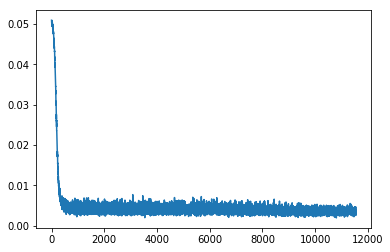

In [187]:
import matplotlib.pyplot as plt

plt.plot(losslist)
plt.show()

In [195]:
orig, masked, _ = get_random_masked_batch(train, batch_size=1, p=0.9)

In [196]:
(orig[0][:100] > 0).sum(), (masked[0][:100] > 0).sum()

(tensor(18, device='cuda:0'), tensor(0, device='cuda:0'))

In [197]:
orig[0][:100]

tensor([4., 3., 4., 0., 0., 3., 3., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.,
        3., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 3., 0., 0., 3., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 4., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 3., 0., 0.,
        2., 0., 3., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [198]:
masked[0][:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')

In [120]:
orig, masked, _ = get_random_masked_batch(negative_feedback_mask, batch_size=1)

In [121]:
orig[0][:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [122]:
masked[0][:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [124]:
orig[0][:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [126]:
torch.nn.functional.dropout(orig[0][:100], training=False)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [144]:
#-----------------Forward Pass----------------------
output = model(masked)

In [148]:
(output.round() > 0).sum()

tensor(381, device='cuda:0')